In [122]:
import pandas as pd
import numpy as np
import ast
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

In [123]:
# Load the dataset
df = pd.read_csv(r'D:\GItHub Reops\Parkinson-Disease-Model\classification\dataset\parkinsons_disease_data_cls.csv')  # Replace with your actual file path

In [124]:
# Drop non-informative columns
df.drop(columns=['PatientID', 'DoctorInCharge'], inplace=True)


In [125]:

# ------------------------
# Convert 'WeeklyPhysicalActivity (hr)' from HH:MM to float hours
def convert_to_hours(time_str):
    if isinstance(time_str, str):
        h, m = map(int, time_str.split(':'))
        return round(h + m / 60.0, 2)
    return np.nan

df['WeeklyPhysicalActivity'] = df['WeeklyPhysicalActivity (hr)'].apply(convert_to_hours)
df.drop(columns=['WeeklyPhysicalActivity (hr)'], inplace=True)


In [126]:

# ------------------------
#  Expand MedicalHistory and Symptoms into binary columns
def expand_dict_column(df, column_name):
    expanded = df[column_name].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else {})
    expanded_df = pd.json_normalize(expanded)
    return expanded_df

med_history_df = expand_dict_column(df, 'MedicalHistory')
symptoms_df = expand_dict_column(df, 'Symptoms')

df.drop(columns=['MedicalHistory', 'Symptoms'], inplace=True)
df = pd.concat([df, med_history_df, symptoms_df], axis=1)


In [127]:
# ------------------------
# Replace 'Yes'/'No' with 1/0
df.replace({'Yes': 1, 'No': 0}, inplace=True)

# ------------------------
# Encode Categorical Columns
categorical_cols = ['Gender', 'Ethnicity', 'EducationLevel', 'Smoking', 
                    'AlcoholConsumption', 'DietQuality', 'SleepQuality']

df[categorical_cols] = df[categorical_cols].fillna('Unknown')
le_dict = {col: LabelEncoder().fit(df[col]) for col in categorical_cols}
for col, le in le_dict.items():
    df[col] = le.transform(df[col])

# ------------------------
# Impute any remaining missing values
imputer = SimpleImputer(strategy='mean')
df[df.columns] = imputer.fit_transform(df)

# Now the dataset is clean and ready
df.head()

,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,DietQuality,SleepQuality,SystolicBP,...,Diabetes,Depression,Stroke,Tremor,Rigidity,Bradykinesia,PosturalInstability,SpeechProblems,SleepDisorders,Constipation
0,64.0,0.0,2.0,3.0,31.243092,0.0,610.0,909.0,774.0,112.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,79.0,1.0,1.0,2.0,32.964518,0.0,509.0,1203.0,1537.0,124.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,85.0,1.0,3.0,3.0,16.092385,0.0,993.0,1137.0,1630.0,97.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,84.0,0.0,2.0,1.0,39.145792,1.0,1921.0,1720.0,1428.0,138.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,59.0,1.0,0.0,3.0,15.987603,1.0,279.0,1204.0,1246.0,169.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


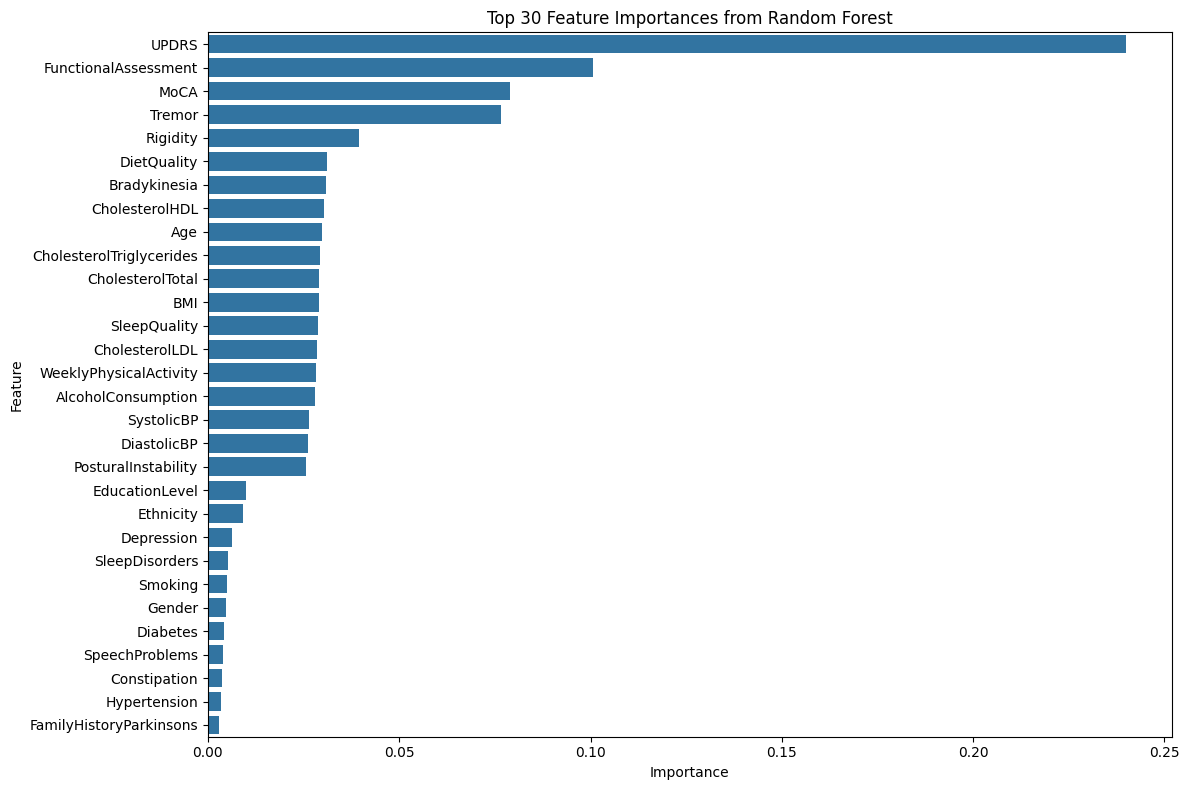

In [128]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Separate features and target
X = df.drop(columns=['Diagnosis'])
y = df['Diagnosis']

# Step 2: Fit RandomForestClassifier to get feature importances
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Step 3: Get feature importances
importances = rf.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})

# Step 4: Sort and plot
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(30))  # Plot top 30
plt.title('Top 30 Feature Importances from Random Forest')
plt.tight_layout()
plt.show()

In [129]:
# Step 5: Select top N features (e.g., top 20)
from sklearn.model_selection import train_test_split

top_n = 19
selected_features = importance_df['Feature'].head(top_n).tolist()

# Final selected features
X_selected = X[selected_features]
y_selected = y

In [130]:
# Train-test split with selected features
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y_selected, test_size=0.2, stratify=y_selected, random_state=42
)

In [131]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Utility function to tune hyperparameters
def tune_and_evaluate(model, param_grid, fixed_params=None, model_name="Model"):
    best_results = []
    for param_name, param_values in param_grid.items():
        grid = {param_name: param_values}
        if fixed_params:
            grid.update(fixed_params)
        clf = GridSearchCV(model, grid, scoring='accuracy', cv=3, n_jobs=-1)
        clf.fit(X_train, y_train)
        best_model = clf.best_estimator_
        y_pred = best_model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        print(f"{model_name} | Best {param_name}: {clf.best_params_[param_name]} | Accuracy: {acc:.4f}")
        best_results.append((param_name, clf.best_params_[param_name], acc))
    return best_results


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error

def manual_tune_logreg(X_train, y_train, X_test, y_test):
    print("Tuning Logistic Regression")

    # Tune C, fix penalty='l2'
    for C_val in [0.01, 1, 100]:
        model = LogisticRegression(C=C_val, penalty='l2', solver='saga', max_iter=1000)
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        acc = accuracy_score(y_test, preds)
        print(f"Penalty=l2 | C={C_val} | Accuracy={acc:.4f} ")

    # Tune penalty, fix C=1 (ignore elasticnet for simplicity)
    for penalty_val in ['l1', 'l2']:
        model = LogisticRegression(C=1, penalty=penalty_val, solver='saga', max_iter=1000)
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        acc = accuracy_score(y_test, preds)
        print(f"C=1 | Penalty={penalty_val} | Accuracy={acc:.4f}")

manual_tune_logreg(X_train, y_train, X_test, y_test)


Tuning Logistic Regression
Penalty=l2 | C=0.01 | Accuracy=0.7506 
Penalty=l2 | C=1 | Accuracy=0.7580 
Penalty=l2 | C=100 | Accuracy=0.7580 
C=1 | Penalty=l1 | Accuracy=0.7580
C=1 | Penalty=l2 | Accuracy=0.7580


In [133]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

def manual_tune_rf(X_train, y_train, X_test, y_test):
    print("Tuning Random Forest")

    best_acc = 0
    best_model = None
    best_preds = None

    # Tune n_estimators, fix max_depth=10
    for n_estimators_val in [50, 100, 200]:
        model = RandomForestClassifier(n_estimators=n_estimators_val, max_depth=10, random_state=42)
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        acc = accuracy_score(y_test, preds)
        print(f"max_depth=10 | n_estimators={n_estimators_val} | Accuracy={acc:.4f}")
        if acc > best_acc:
            best_acc = acc
            best_model = model
            best_preds = preds

    # Tune max_depth, fix n_estimators=100
    for max_depth_val in [5, 10, None]:
        model = RandomForestClassifier(n_estimators=100, max_depth=max_depth_val, random_state=42)
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        acc = accuracy_score(y_test, preds)
        print(f"n_estimators=100 | max_depth={max_depth_val} | Accuracy={acc:.4f}")
        if acc > best_acc:
            best_acc = acc
            best_model = model
            best_preds = preds

    print("\n=== Best Model Classification Report ===")
    print(classification_report(y_test, best_preds))

manual_tune_rf(X_train, y_train, X_test, y_test)


Tuning Random Forest
max_depth=10 | n_estimators=50 | Accuracy=0.9160
max_depth=10 | n_estimators=100 | Accuracy=0.9333
max_depth=10 | n_estimators=200 | Accuracy=0.9432
n_estimators=100 | max_depth=5 | Accuracy=0.8864
n_estimators=100 | max_depth=10 | Accuracy=0.9333
n_estimators=100 | max_depth=None | Accuracy=0.9407

=== Best Model Classification Report ===
              precision    recall  f1-score   support

         0.0       0.94      0.91      0.92       152
         1.0       0.95      0.96      0.95       253

    accuracy                           0.94       405
   macro avg       0.94      0.94      0.94       405
weighted avg       0.94      0.94      0.94       405



In [134]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

def manual_tune_xgb(X_train, y_train, X_test, y_test):
    print("🔍 Tuning XGBoost Classifier Manually")

    best_acc = 0
    best_model = None
    best_preds = None

    # Tune n_estimators (fix max_depth=10)
    print("\n🔧 Tuning n_estimators (max_depth=10)")
    for n in [50, 100, 200]:
        model = XGBClassifier(n_estimators=n, max_depth=10, use_label_encoder=False, eval_metric='logloss', random_state=42)
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        acc = accuracy_score(y_test, preds)
        print(f"n_estimators={n} | max_depth=10 | Accuracy={acc:.4f}")
        if acc > best_acc:
            best_acc = acc
            best_model = model
            best_preds = preds

    # Tune max_depth (fix n_estimators=100)
    print("\n🔧 Tuning max_depth (n_estimators=100)")
    for depth in [5, 10, 15]:
        model = XGBClassifier(n_estimators=100, max_depth=depth, use_label_encoder=False, eval_metric='logloss', random_state=42)
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        acc = accuracy_score(y_test, preds)
        print(f"n_estimators=100 | max_depth={depth} | Accuracy={acc:.4f}")
        if acc > best_acc:
            best_acc = acc
            best_model = model
            best_preds = preds

    print(f"Accuracy: {best_acc:.4f}")
    print(classification_report(y_test, best_preds))

# Call the function
manual_tune_xgb(X_train, y_train, X_test, y_test)


🔍 Tuning XGBoost Classifier Manually

🔧 Tuning n_estimators (max_depth=10)
n_estimators=50 | max_depth=10 | Accuracy=0.9259
n_estimators=100 | max_depth=10 | Accuracy=0.9259
n_estimators=200 | max_depth=10 | Accuracy=0.9259

🔧 Tuning max_depth (n_estimators=100)
n_estimators=100 | max_depth=5 | Accuracy=0.9358
n_estimators=100 | max_depth=10 | Accuracy=0.9259
n_estimators=100 | max_depth=15 | Accuracy=0.9235
Accuracy: 0.9358
              precision    recall  f1-score   support

         0.0       0.91      0.91      0.91       152
         1.0       0.95      0.95      0.95       253

    accuracy                           0.94       405
   macro avg       0.93      0.93      0.93       405
weighted avg       0.94      0.94      0.94       405

